<h1><center>Autoencoder on MNIST using Keras<center></h1>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Importing Keras

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
print("Using tensorflow version " + str(tf.__version__))
print("Using keras version " + str(keras.__version__))

Using tensorflow version 2.8.0
Using keras version 2.8.0


## Loading and preparing the MNIST dataset

Load the MNIST dataset via keras.datasets. Again, turn train and test labels into one-hot encoding, and reshape and normalize data as in the first exercise. 

In [3]:
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g., ImageNet)

from keras.datasets import mnist
# START CODE HERE

(train_images, y_train), (test_images, y_test) = keras.datasets.mnist.load_data()
print('Size of training set is ',train_images.shape)
print('Size of testint set is ',test_images.shape)




11501568/11490434 [==============================] - 0s 0us/step
Size of training set is  (60000, 28, 28)
Size of testint set is  (10000, 28, 28)


In [4]:
# Do you remember about one-hot encoding ?
from keras.utils.np_utils import to_categorical
# START CODE HERE
train_labels = to_categorical(y_train, num_classes=10)
test_labels = to_categorical(y_test, num_classes=10)
print('The label of the train set is:', train_labels.shape)
print('The label of the test set is:', test_labels.shape)
# END CODE HERE

The label of the train set is: (60000, 10)
The label of the test set is: (10000, 10)


In [5]:
# Reshape to proper images with 1 color channel according to backend scheme
img_rows, img_cols = train_images.shape[1], train_images.shape[2]
train_images_p = train_images.reshape((-1, img_rows*img_cols))
test_images_p = test_images.reshape((-1, img_rows*img_cols))


# Cast pixels from uint8 to float32
train_images_p = train_images_p.astype('float32')

# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time ?
# START CODE HERE
mean = train_images_p.mean()
std = train_images_p.std()

train_images_n = np.array([(x-mean)/std for x in train_images_p])
test_images_n = np.array([(x-mean)/std for x in test_images_p])

print("The mean of our test images is", test_images_n.mean(), ", its variance is", test_images_n.std() )
print("The mean of our train images is", train_images_n.mean(), ", its variance is", train_images_n.std() )

# END CODE HERE



The mean of our test images is 0.0060174568 , its variance is 1.0077008
The mean of our train images is -3.4560264e-07 , its variance is 0.9999998


## Autoencoder and PCA

First, we will try to connect the representation produced by Principal Component Analysis with what is learnt by a simple, linear, autoencoder. We will use the ```scikit-learn``` implementation of the ```PCA``` to obtain the two first components (hint: use the attribute ```.components_```), and visualize them:

The first 2 PCA components of the training set are: [[-3.6661352e-09 -1.2969747e-08 -1.5228011e-09 ... -5.3099647e-10
  -5.3099647e-10 -5.3099647e-10]
 [-8.1302014e-09 -9.0449497e-09 -3.5283765e-10 ... -5.0823584e-10
  -5.0823584e-10 -5.0823584e-10]]


Text(0.5, 1.0, 'PC2')

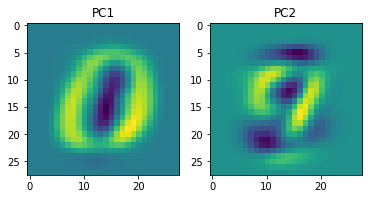

In [6]:
from sklearn.decomposition import PCA

# Let's find the first 2 PCA components
num_components = 2
# START CODE HERE
pca_train = PCA(n_components=num_components)
PC_train = pca_train.fit_transform(train_images_n)
print("The first 2 PCA components of the training set are:", pca_train.components_)

# END CODE HERE

# Reshape so they resemble images and we can print them
# START CODE HERE

PC1= pca_train.components_[0].reshape(28,28)
PC2= pca_train.components_[1].reshape(28,28)

# END CODE HERE

# Show the reshaped principal components
# START CODE HERE
fig, axes = plt.subplots(1, 2, figsize=(6,6))
axes[0].imshow(PC1)
axes[0].set_title("PC1")
axes[1].imshow(PC2)
axes[1].set_title("PC2")
# END CODE HERE

In [7]:
# Print the variance explained by those components
print("The variance of the training set is",pca_train.explained_variance_)

The variance of the training set is [53.901363 39.411995]


**Comment on the visualization in relation to the variance explained by only keeping the two principal components.**

Now, we will use Keras to implement the autoencoder. You can take a look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf) for some basic commands to use keras.

In this first case, we implement a **simple linear autoencoder**. Build it in order to have the same capacity as the PCA decomposition (2 hidden dimensions !) we made just above. 

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD

In [9]:
# Input layer
input_layer = Input(shape=(784,))

In [10]:
# Encoding layer
latent_view = Dense(2)(input_layer)

In [11]:
# Decoding layer
output_layer = Dense(784, activation='sigmoid')(latent_view)

In [12]:
ae_model = Model(input_layer, output_layer, name='ae_model')
ae_model.summary()

Model: "ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 2)                 1570      
                                                                 
 dense_1 (Dense)             (None, 784)               2352      
                                                                 
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________


What loss shoud we use ? Choose the usual one and import it directly from Keras. You can use a simple ```SGD``` optimizer, and then compile the model; finally, train it to rebuild images from the original examples.  

In [13]:
from tensorflow.keras.losses import MSE
loss = 'MSE'


optimizer = SGD(lr=1e-1) 
ae_model.compile(optimizer=optimizer, loss=loss) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [14]:
batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(train_images_n,
                       train_images_n,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images_n,test_images_n))

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 1.0264 - val_loss: 0.8151
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.8044 - val_loss: 0.8040
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.7986 - val_loss: 0.7997
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.7933 - val_loss: 0.7927
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.7847 - val_loss: 0.7831
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.7768 - val_loss: 0.7770
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.7722 - val_loss: 0.7736
Epoch 8/10
469/469 [==============================] - 2s 5ms/step - loss: 0.7695 - val_loss: 0.7715
Epoch 9/10
469/469 [==============================] - 2s 5ms/step - loss: 0.7676 - val_loss: 0.7699
Epoch 10/10
469/469 [==============================] - 2s 5ms/step - loss: 0.7664 - val_loss: 0.7689

Assuming that the name of your layer (obtained through the command ```model.summary()```) is ```'layer'```, here is the way to obtained the weights. Visualize the weights of the encoder and compare them to the two components obtained through the PCA.

In [16]:
weights, bias = ae_model.get_layer('dense').get_weights()

Text(0.5, 1.0, 'Second dimension of the encoder')

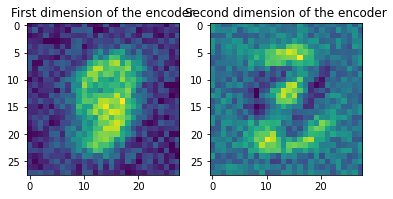

In [17]:
# Show the two dimensions of the encoder, in a similar manner to the principal components
# (after reshaping them as images !)
# START CODE HERE
fig, axes = plt.subplots(1, 2, figsize=(6,6))
axes[0].imshow(weights.T[0].reshape(28,28))
axes[0].set_title("First dimension of the encoder")
axes[1].imshow(weights.T[1].reshape(28,28))
axes[1].set_title("Second dimension of the encoder")
# END CODE HERE

Now, visualize the images rebuild by the network !

In [18]:
# Select a few images at random: look from n
n = np.random.randint(0,len(test_images_n)-5)

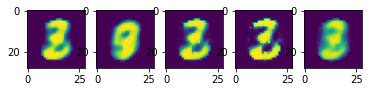

In [19]:
# Plot a few images from n  
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):
    # START CODE HERE
    ax[i].imshow((ae_model.predict(test_images_n)[a]).reshape(28,28))
    # END CODE HERE

In [ ]:
# Get the prediction from the model 
# START CODE HERE
...
# END CODE HERE

# ... and plot them 
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):
    # START CODE HERE
    ...
    # END CODE HERE

Do the same ( = build a new model) with a latent dimension that is largely higher than 2. Compare the visualizations and the images that are rebuilt. 

Model: "ae_model_h"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 2)                 1570      
                                                                 
 dense_3 (Dense)             (None, 784)               2352      
                                                                 
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


469/469 [==============================] - 3s 5ms/step - loss: 0.8471 - val_loss: 0.7867
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.7779 - val_loss: 0.7765
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.7712 - val_loss: 0.7721
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.7681 - val_loss: 0.7700
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.7662 - val_loss: 0.7681
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.7645 - val_loss: 0.7666
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.7635 - val_loss: 0.7659
Epoch 8/10
469/469 [==============================] - 2s 5ms/step - loss: 0.7628 - val_loss: 0.7651
Epoch 9/10
469/469 [==============================] - 2s 5ms/step - loss: 0.7621 - val_loss: 0.7645
Epoch 10/10
469/469 [==============================] - 2s 5ms/step - loss: 0.7616 - val_loss: 0.7641


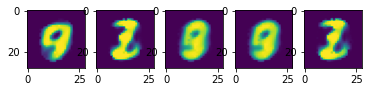

In [20]:
# START CODE HERE
latent_view_h = Dense(32)(input_layer)
output_layer_h = Dense(784, activation='sigmoid')(latent_view)
ae_model_h = Model(input_layer, output_layer_h, name='ae_model_h')
ae_model_h.summary()

optimizer = SGD(lr=1e-1) 
ae_model_h.compile(optimizer=optimizer, loss=loss) 

batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model_h.fit(train_images_n,
                       train_images_n,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images_n,test_images_n))


# Select a few images at random: look from n
n = np.random.randint(0,len(test_images_n)-5)
# Plot a few images from n  
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):

    ax[i].imshow((ae_model_h.predict(test_images_n)[a]).reshape(28,28))




# END CODE HERE

## Denoising auto-encoder 

Now, we can implement a **de-noising autoencoder**. The following function will transform an array of images by adding it random noise. Create a new autoencoder model, this time with **more layers** and **non-linear activations** (like the ReLU) and train it to rebuild the de-noised images. Display some testing images, with noise, and re-built. 

In [21]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return noisy_array

In [22]:
# Create a copy of the data with added noise
noisy_train_images = noise(train_images_n)
noisy_test_images = noise(test_images_n)

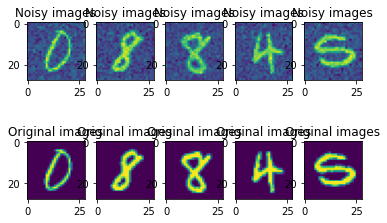

In [23]:
# Visualize some of the images with noise against the originals
# START CODE HERE
# Select a few images at random: look from n
n = np.random.randint(0,len(test_images)-5)

# Plot a few images from n  
f, ax = plt.subplots(2,5)
for i,a in enumerate(range(n,n+5)):
    ax[0,i].imshow(noisy_test_images[a].reshape(28,28))
    ax[0,i].set_title("Noisy images")
    ax[1,i].imshow(test_images_n[a].reshape(28,28),label='Original')
    ax[1,i].set_title("Original images")


In [24]:
# Build a new model with more layers and Relu activations
# START CODE HERE
latent_view_noise = Dense(32)(input_layer)
output_layer = Dense(784, activation='relu')(latent_view_noise)
ae_model_noise = Model(input_layer, output_layer, name='ae_model_noise')
ae_model_noise.summary()
# END CODE HERE

Model: "ae_model_noise"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_4 (Dense)             (None, 32)                25120     
                                                                 
 dense_5 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Compile it but here, use noised data as inputs !
# START CODE HERE
optimizer = SGD(lr=1e-1) 
ae_model_noise.compile(optimizer=optimizer, loss=loss) 

batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model_noise.fit(train_images_n,
                       train_images_n,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images_n,test_images_n))
# END CODE HERE

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


469/469 [==============================] - 3s 6ms/step - loss: 0.7727 - val_loss: 0.6314
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.5615 - val_loss: 0.5076
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.4782 - val_loss: 0.4472
Epoch 4/10
469/469 [==============================] - 3s 5ms/step - loss: 0.4343 - val_loss: 0.4164
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 0.4085 - val_loss: 0.3945
Epoch 6/10
469/469 [==============================] - 3s 5ms/step - loss: 0.3892 - val_loss: 0.3770
Epoch 7/10
469/469 [==============================] - 4s 7ms/step - loss: 0.3746 - val_loss: 0.3657
Epoch 8/10
469/469 [==============================] - 3s 5ms/step - loss: 0.3646 - val_loss: 0.3566
Epoch 9/10
469/469 [==============================] - 3s 5ms/step - loss: 0.3558 - val_loss: 0.3485
Epoch 10/10
469/469 [==============================] - 3s 6ms/step - loss: 0.3490 - val_loss: 0.3429


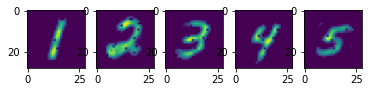

In [26]:
# Visualize the images rebuilt by the model !
# START CODE HERE
# Select a few images at random: look from n
n = np.random.randint(0,len(test_images_n)-5)
# Plot a few images from n  
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):

    ax[i].imshow((ae_model_noise.predict(noisy_test_images)[a]).reshape(28,28))

# END CODE HERE

The noise that was in the images is gone after we rebuild them.

**Assuming that we normalize the images to be in the 0-1 range, what other loss function could we use ?**

We could use binary crossentropy for images in the 0-1 range.